# Load Data

In [46]:
from pathlib import Path
import sys

# Go up one folder from the current notebook directory
sys.path.append(str(Path().resolve().parent))

from src.data_access import load_housing_data

from src.config import (
    IMPUTE_PLAN, DROP_COLS,
    ORDINAL_MAPS, ORDINAL_OBJECTS,
    NOMINAL_COLS, RIGHT_SKEWED_COLS, SKEWED_AND_BINARY_COLS,YEAR_COLS, COLLAPSE_TO_BINARY_COLS,
    FEATURES, CONFIG_VERSION
)

ImportError: cannot import name 'ENGINEERED_FEATURES' from 'src.config' (D:\ml-projects\housing-prices\src\config.py)

##### Config-driven preprocessing — this notebook reads all EDA decisions (imputation, ordinals, column buckets) from src/config.py so updates propagate without changing code.

In [2]:
train, test = load_housing_data()

In [3]:
TARGET = "SalePrice"

X = train.drop(columns=[TARGET] + [c for c in DROP_COLS if c in train.columns])
y = train[TARGET]

## Column buckets (from config)

In [4]:
def present(df, cols):
    return [c for c in cols if c in df.columns]

# Direct mirrors of config (filtered once against X)
obj_ordinal_cols        = present(X, ORDINAL_OBJECTS)
nominal_cols            = present(X, NOMINAL_COLS)
right_skewed_cols       = present(X, RIGHT_SKEWED_COLS)
skewed_and_binary       = present(X, SKEWED_AND_BINARY_COLS)
collapse_to_binary_cols = present(X, COLLAPSE_TO_BINARY_COLS)
year_cols               = present(X, YEAR_COLS) 

# For the pipeline that uses the union of “binary & skewed” inputs
from collections import OrderedDict
binary_and_skewed_cols = list(OrderedDict.fromkeys(
    right_skewed_cols + skewed_and_binary + collapse_to_binary_cols
))

#### These lists are the **single source of truth** for the transformers built below.


# Imputation Column Transformer

**Imputation plan**

- _Structural None_ → informative absence (fill `"None"`),  
- _Mode fill_ → nominal/ordinal columns,  
- _Zero fill_ → zero-inflated numerics,  
- _Median fill_ → continuous numerics and years.

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

imputer = ColumnTransformer(
    transformers=[
        ("none_imputer",   SimpleImputer(strategy="constant", fill_value="None"), present(X, IMPUTE_PLAN.structural_none)),
        ("mode_imputer",   SimpleImputer(strategy="most_frequent"),               present(X, IMPUTE_PLAN.mode_fill)),
        ("zero_imputer",   SimpleImputer(strategy="constant", fill_value=0),      present(X, IMPUTE_PLAN.zero_fill)),
        ("median_imputer", SimpleImputer(strategy="median"),                      present(X, IMPUTE_PLAN.median_fill + IMPUTE_PLAN.year_cols)),
    ],
   # each group comes from config; present(...) makes this robust to schema drift
    remainder="passthrough",              
    verbose_feature_names_out=False,      # preserve original names (nicer sklearn column names)

).set_output(transform="pandas")

# Nominal Pipeline

1) Merge rare levels per column (threshold=10) into `"Other"` to stabilize one-hot.  
2) One-hot encode with `handle_unknown="ignore"` to avoid train/test level mismatches.

In [6]:
from sklearn.base import TransformerMixin, BaseEstimator

class CollapseRareCategories(TransformerMixin, BaseEstimator):
    def __init__(self, cols, threshold=10):
        self.cols = cols
        self.threshold = threshold
        self.to_transform_ = {}
        self.feature_names_in_ = None
    # threshold counts per level (per-column) below which values collapse to "Other"

    def fit(self, X, y=None):
        # Record input feature names
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else np.arange(X.shape[1])
        
        # record which levels to keep per column; everything else → "Other"
        for feature in self.cols:
            counts = X[feature].value_counts()
            rare_cats = counts[counts < self.threshold].index.tolist()
            self.to_transform_[feature] = rare_cats
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        # apply per-column keep-map; unseen levels also collapse to "Other"
        for feature, rare_cats in self.to_transform_.items():
            if pd.api.types.is_numeric_dtype(X_copy[feature]):
                X_copy[feature] = X_copy[feature].astype("object")
            X_copy.loc[X_copy[feature].isin(rare_cats), feature] = "Other"
            X_copy[feature] = X_copy[feature].astype(str)
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

nominal_pipeline = Pipeline([
    ('collapse', CollapseRareCategories(cols=nominal_cols, threshold=10)),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# Binary, skewed, collapse_to_binary Pipeline

In [8]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.preprocessing import StandardScaler

binary_and_skewed_ct = ColumnTransformer(
    transformers=[
        # right-skewed numerics → log1p then scale
        ('log_right',   FunctionTransformer(np.log1p, validate=False), right_skewed_cols),
        ('scale_right', StandardScaler(),                               right_skewed_cols),

        # skewed-and-binary numerics → log1p then scale
        ('log_skewbin',   FunctionTransformer(np.log1p, validate=False), skewed_and_binary),
        ('scale_skewbin', StandardScaler(),                               skewed_and_binary),

        # collapse-to-binary numerics + also make binary copies for skewed-and-binary
        ('binary_flags', FunctionTransformer(lambda X: (X > 0).astype(int), validate=False),
                         list(OrderedDict.fromkeys(skewed_and_binary + collapse_to_binary_cols))),
    ]
)

## Object Ordinal Pipeline

In [9]:
obj_ordinal_cols = present(X, ORDINAL_OBJECTS)
ordinal_mappings = {k: ORDINAL_MAPS[k] for k in obj_ordinal_cols}

In [10]:
class OrdinalMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mappings=ordinal_mappings):
        self.mappings = mappings
        self.features_names_in_ = None

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col, mapping in self.mappings.items():
            if col in X_copy.columns:
                X_copy[col] = X_copy[col].map(mapping)
                
        return X_copy

    def get_features_names_out(self):
        return self.features_names_in_

In [11]:
ordinal_pipeline = Pipeline([
    ('mapper', OrdinalMapper()),
    ('scaler', StandardScaler())
])

## year_cols pipeline

**Year → Age**

Convert `YearBuilt`, `YearRemodAdd`, `GarageYrBlt` to ages relative to `YrSold.

In [12]:
class ToAge(BaseEstimator, TransformerMixin):
    def __init__(self, reference_col="YrSold"):
        self.reference_col = reference_col
        self.feature_names_in_ = None
        self.reference_year_ = None

    def fit(self, X, y=None):
        # Save reference year(s) from X
        if self.reference_col in X.columns:
            self.reference_year_ = X[self.reference_col]
        else:
            raise ValueError(f"{self.reference_col} not found in input DataFrame")
        self.feature_names_in_ = X.columns
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Subtract reference year from all other year cols
        for col in X_copy.columns:
            if col != self.reference_col:
                X_copy[col] = X_copy[self.reference_col] - X_copy[col]
                
        # drop the raw YrSold
        X_copy = X_copy.drop(columns=[self.reference_col])
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return [col for col in self.feature_names_in_ if col != self.reference_col]

In [40]:
year_pipeline = Pipeline([
    ('to_age', ToAge(reference_col='YrSold')),  # if your class takes it
    ('scaler', StandardScaler())
])

In [59]:
'FullBath' in train.columns

True

## Engineered Features Pipeline

In [95]:
class AddEngFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, TotalLivingArea=True, TotalPorchSF=True, OverallGrade=True, TotalBathrooms=True):
        self.TotalLivingArea = TotalLivingArea
        self.TotalPorchSF = TotalPorchSF
        self.OverallGrade = OverallGrade
        self.TotalBathrooms = TotalBathrooms
        
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        if self.TotalLivingArea:
            X["TotalLivingArea"] = X["GrLivArea"] + X["TotalBsmtSF"]

        if self.TotalPorchSF:
            X["TotalPorchSF"] = (
                X["WoodDeckSF"] + X["OpenPorchSF"] +
                X["EnclosedPorch"] + X["3SsnPorch"] +
                X["ScreenPorch"]
        )

        if self.OverallGrade:
            X["OverallGrade"] = X["OverallQual"] * X["OverallCond"]
        
        if self.TotalBathrooms:
            X["TotalBathrooms"] = (
                X["FullBath"] + 0.5*X["HalfBath"] +
                X["BsmtFullBath"] + 0.5*X["BsmtHalfBath"]
            )
        return X

In [96]:
eng_feat_pipeline = Pipeline([
    ('add_eng_feat', AddEngFeatures()),
    ('scaler', StandardScaler())
])

In [97]:
cols_to_eng = ["GrLivArea", "TotalBsmtSF", 
               "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
              "OverallQual", "OverallCond",
              "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]

# Preprocessor pipeline

**Full feature CT** — per-bucket pipelines combined in a single `ColumnTransformer`.

In [98]:
preprocessor_ct = ColumnTransformer(
    transformers=[
        ('nominal', nominal_pipeline, nominal_cols),
        ('binary_and_skewed', binary_and_skewed_ct, binary_and_skewed_cols),
        ('ordinal', ordinal_pipeline, obj_ordinal_cols),
        ('year', year_pipeline, year_cols),
        ('eng_feat', eng_feat_pipeline, cols_to_eng)
    ],
    remainder='drop' # only the curated groups flow through; others are intentionally dropped
)

In [99]:
import pandas as pd

# Full preprocessing pipeline
preprocessor_pipeline = Pipeline([
    ('imputer', imputer),
    ('features', preprocessor_ct)
])

# Model Evaluation

### Baseline model leaderboard (5-fold CV)

We wrap each regressor in the same preprocessing pipeline and score with **RMSE** (lower is better).
All scores are computed via cross-validation on train-only folds to avoid leakage.

- We evaluate all models with the same splitter: RepeatedKFold(n_splits=5, n_repeats=3, random_state=42).

- This reduces variance vs. a single 5-fold split and keeps scores comparable across the leaderboard and all hyperparameter searches.

- Metric: RMSE, using neg_root_mean_squared_error in scikit-learn

In [69]:
# --- CV + metric (define once and reuse everywhere) ---
from sklearn.model_selection import RepeatedKFold

N_SPLITS   = 5
N_REPEATS  = 3
RANDOM_SEED = 42
SCORING    = "neg_root_mean_squared_error"

cv = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_SEED)

### Models evaluation (same preprocessing for all)
Quick set of reasonable defaults to get a **baseline leaderboard**.  

In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    "Linear"       : LinearRegression(),
    "Ridge"        : Ridge(alpha=1.0),
    "Lasso"        : Lasso(alpha=0.001, max_iter=10000),
    "ElasticNet"   : ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    "RandomForest" : RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GBM"          : GradientBoostingRegressor(random_state=42),
    "SVR"          : SVR(C=10, kernel='rbf')
}

#### Wrap each regressor with the **same preprocessing** and a **target transform**.  
uses TransformedTargetRegressor because target is skewed

In [71]:
from sklearn.compose import TransformedTargetRegressor

def make_model(reg):
    pipe = Pipeline([
        ('preprocess', preprocessor_pipeline),  
        ('model', reg)
    ])
    return TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    )

In [72]:
from sklearn.model_selection import cross_val_score

results = []
for name, reg in models.items():
    model = make_model(reg)
    scores = cross_val_score(
        model,
        X, y,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1
    )
    # sklearn returns negatives for loss metrics → flip sign back to positive RMSE
    results.append((name, -scores.mean(), scores.std()))

results = sorted(results, key=lambda t: t[1])
print("\n=== CV Leaderboard (RMSE, lower is better) ===")

for name, rmse, sd in results:
    print(f"{name:12s}  RMSE = {rmse:,.3f}  ± {sd:,.3f}")


=== CV Leaderboard (RMSE, lower is better) ===
GBM           RMSE = 26,956.459  ± 6,366.796
SVR           RMSE = 27,571.961  ± 5,172.416
RandomForest  RMSE = 29,820.246  ± 5,179.487
Ridge         RMSE = 37,386.173  ± 24,027.876
Linear        RMSE = 37,473.229  ± 23,864.808
ElasticNet    RMSE = 38,710.877  ± 29,257.044
Lasso         RMSE = 41,395.152  ± 33,510.353


**Reading the table:** pick the smallest RMSE, but also look at the ±SD for stability.  
Next step: shortlist the top 2 models for a quick tune (GBR and SVR here).

### Hyperparameter search plan

Goal: compare GBM and SVR fairly using the **same preprocessing pipeline** and **same CV splitter**.  

# GBM

In [117]:
gbr = GradientBoostingRegressor(
    random_state=RANDOM_SEED,
    loss='squared_error'
)

gbr_est = make_model(gbr)

In [118]:
#randomized search space 
gbr_param_dist = {
    #GBM hyperparameters
    'regressor__model__n_estimators':    randint(300, 1200),
    'regressor__model__learning_rate':   uniform(0.03, 0.17),   # ~0.03–0.20
    'regressor__model__max_depth':       randint(2, 5),
    'regressor__model__min_samples_leaf': randint(2, 8),
    'regressor__model__subsample':       uniform(0.6, 0.4),     # 0.6–1.0
    'regressor__model__max_features':    ['sqrt', None],

    # Preprocessing knobs
    'regressor__preprocess__features__nominal__collapse__threshold': [5, 10, 20],
    'regressor__preprocess__features__nominal__one_hot__drop': [None, 'if_binary'],

    # Engineered-feature toggles
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalLivingArea': [True, False],
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalPorchSF': [True, False],
    'regressor__preprocess__features__eng_feat__add_eng_feat__OverallGrade': [True, False],
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalBathrooms': [True, False],
}

In [119]:
#randomized search
gbr_search = RandomizedSearchCV(
    estimator=gbr_est,
    param_distributions=gbr_param_dist,
    n_iter=100,                            
    scoring=SCORING,
    cv=cv,
    n_jobs=-1,                              
    verbose=1,
    random_state=RANDOM_SEED
)

In [120]:
gbr_search.fit(X, y)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


,estimator,TransformedTa..._state=42))]))
,param_distributions,"{'regressor__model__learning_rate': <scipy.stats....001FFECBBCE50>, 'regressor__model__max_depth': <scipy.stats....001FFECB929E0>, 'regressor__model__max_features': ['sqrt', None], 'regressor__model__min_samples_leaf': <scipy.stats....001FFEC3ACFA0>, ...}"
,n_iter,100
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,RepeatedKFold...ndom_state=42)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [121]:
best_idx   = gbr_search.best_index_
mean_rmse  = -gbr_search.cv_results_['mean_test_score'][best_idx]  # negate to get +RMSE
std_rmse   =  gbr_search.cv_results_['std_test_score'][best_idx]   # std is already ≥0

print(f"Best RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print("Best Params:")
for k, v in gbr_search.best_params_.items():
    print(f"  {k}: {v}")

Best RMSE: 26469.611 ± 8741.913
Best Params:
  regressor__model__learning_rate: 0.15764808152455456
  regressor__model__max_depth: 2
  regressor__model__max_features: sqrt
  regressor__model__min_samples_leaf: 2
  regressor__model__n_estimators: 1097
  regressor__model__subsample: 0.9610211626718267
  regressor__preprocess__features__eng_feat__add_eng_feat__OverallGrade: False
  regressor__preprocess__features__eng_feat__add_eng_feat__TotalBathrooms: False
  regressor__preprocess__features__eng_feat__add_eng_feat__TotalLivingArea: False
  regressor__preprocess__features__eng_feat__add_eng_feat__TotalPorchSF: True
  regressor__preprocess__features__nominal__collapse__threshold: 10
  regressor__preprocess__features__nominal__one_hot__drop: None


### Since the rmse barely moverd and the std got worse, lets create a paramgrid around the original params of the base gmb

In [132]:
gbr_est = make_model(models["GBM"])  # TransformedTargetRegressor
all_params = gbr_est.get_params()

# Just the inner GBM’s hyperparams:
gbm_params = {k.replace("regressor__model__",""): v
              for k, v in all_params.items()
              if k.startswith("regressor__model__")}
print(gbm_params)


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### More regularized than the base gbm

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# --- base model (classic GBM) ---
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, loss="squared_error")
gbr_est = make_model(gbr)

# lock engineered toggles for stability so the grid stays small:
gbr_est.set_params(
    regressor__preprocess__features__eng_feat__add_eng_feat__TotalPorchSF=True,
    regressor__preprocess__features__eng_feat__add_eng_feat__TotalLivingArea=False,
    regressor__preprocess__features__eng_feat__add_eng_feat__OverallGrade=False,
    regressor__preprocess__features__eng_feat__add_eng_feat__TotalBathrooms=False,
)

# --- very small, stability-oriented grid (~32 combos = ~480 fits with 15 folds) ---
gbr_param_grid = {
    # ===== Model hyperparameters (more regularized around your baseline) =====
    # Baseline: learning_rate=0.1  → try slightly lower to regularize
    'regressor__model__learning_rate': [0.05, 0.075],          # ↓ vs 0.1 (smoother boosting steps)

    # Baseline: n_estimators=100 → pair lower LR with more trees (still small search)
    'regressor__model__n_estimators': [300, 800],                    # ↑ vs 100; complements lower LR without exploding grid

    # Baseline: max_depth=3 → keep shallow/very shallow trees
    'regressor__model__max_depth': [2, 3],                      # ≤ baseline — controls tree complexity

    # Baseline: min_samples_leaf=1 → increase leaf size to reduce variance
    'regressor__model__min_samples_leaf': [2, 3],               # ↑ vs 1 — fewer tiny leaves, better generalization

    # Baseline: subsample=1.0 → add a touch of stochasticity
    'regressor__model__subsample': [0.85, 1],                      # < 1.0 — stochastic GBM often lowers variance

    # Baseline: max_features=None → consider using fewer features per split
    'regressor__model__max_features': ['sqrt'],                 # fewer features per split = regularization

    # ===== Preprocessing knobs (kept small) =====
    # You previously saw ~10 working; compare with a slightly stronger collapse
    'regressor__preprocess__features__nominal__collapse__threshold': [10, 15],  # 10≈baseline, 20=more regularized dummies

    # Keep drop logic simple/consistent
    'regressor__preprocess__features__nominal__one_hot__drop': [None, 'if_binary'],  # match prior setting & a safe variant
}

gbr_grid = GridSearchCV(
    estimator=gbr_est,
    param_grid=gbr_param_grid,
    scoring=SCORING,          # "neg_root_mean_squared_error"
    cv=cv,                    # your RepeatedKFold (5×3=15 folds)
    n_jobs=-1,
    verbose=1,
    refit=True
)

gbr_grid.fit(X, y)

# report
best_idx  = gbr_grid.best_index_
mean_rmse = -gbr_grid.cv_results_['mean_test_score'][best_idx]
std_rmse  =  gbr_grid.cv_results_['std_test_score'][best_idx]

print(f"Best RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print("Best Params:")
for k, v in gbr_grid.best_params_.items():
    print(f"  {k}: {v}")


Fitting 15 folds for each of 128 candidates, totalling 1920 fits
Best RMSE: 25949.231 ± 7645.404
Best Params:
  regressor__model__learning_rate: 0.075
  regressor__model__max_depth: 3
  regressor__model__max_features: sqrt
  regressor__model__min_samples_leaf: 2
  regressor__model__n_estimators: 800
  regressor__model__subsample: 1
  regressor__preprocess__features__nominal__collapse__threshold: 15
  regressor__preprocess__features__nominal__one_hot__drop: None


## SVR

In [135]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR(kernel='rbf')  # base

svr_est = make_model(svr)

# lock engineered toggles to the combo that worked best for trees, or try these two if unsure
svr_param_grid = {
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalPorchSF': [True],
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalLivingArea': [False],
    'regressor__preprocess__features__eng_feat__add_eng_feat__OverallGrade': [False],
    'regressor__preprocess__features__eng_feat__add_eng_feat__TotalBathrooms': [False],

    # SVR core (tight, around sensible defaults)
    'regressor__model__C': [3, 10],          # around 1–10; 10 often strong
    'regressor__model__epsilon': [0.05, 0.1],# controls insensitivity band
    'regressor__model__gamma': ['scale', 0.03], # 'scale' + a modest manual value
}

svr_grid = GridSearchCV(
    estimator=svr_est,
    param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,           # your RepeatedKFold/Stratified variant
    n_jobs=-1,
    verbose=1,
    refit=True
)
svr_grid.fit(X, y)

best_idx  = svr_grid.best_index_
mean_rmse = -svr_grid.cv_results_['mean_test_score'][best_idx]
std_rmse  =  svr_grid.cv_results_['std_test_score'][best_idx]
print(f"SVR Best RMSE: {mean_rmse:.3f} ± {std_rmse:.3f}")
print("Best Params:", svr_grid.best_params_)


Fitting 15 folds for each of 8 candidates, totalling 120 fits
SVR Best RMSE: 25518.001 ± 6089.827
Best Params: {'regressor__model__C': 3, 'regressor__model__epsilon': 0.05, 'regressor__model__gamma': 'scale', 'regressor__preprocess__features__eng_feat__add_eng_feat__OverallGrade': False, 'regressor__preprocess__features__eng_feat__add_eng_feat__TotalBathrooms': False, 'regressor__preprocess__features__eng_feat__add_eng_feat__TotalLivingArea': False, 'regressor__preprocess__features__eng_feat__add_eng_feat__TotalPorchSF': True}


# Out-of-fold predictions

In [142]:
from sklearn.base import clone

def oof_predict_repeated(estimator, X: pd.DataFrame, y: pd.Series, cv):
    """
    Out-of-fold predictions for repeated CV without converting X to numpy.
    Preserves column names required by ColumnTransformer.
    """
    # Ensure pandas types
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be a pandas DataFrame (with the same column names used in preprocessing).")
    if not isinstance(y, (pd.Series, pd.DataFrame)):
        y = pd.Series(y)

    preds_sum   = pd.Series(0.0, index=y.index, dtype=float)
    preds_count = pd.Series(0,   index=y.index, dtype=int)

    splits = list(cv.split(X, y))  # freeze identical splits for all models

    for tr_idx, te_idx in splits:
        est = clone(estimator)
        est.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        p = est.predict(X.iloc[te_idx])
        preds_sum.iloc[te_idx]   += p
        preds_count.iloc[te_idx] += 1

    return (preds_sum / preds_count).to_numpy()

In [143]:
svr_best = svr_grid.best_estimator_
gbr_best = gbr_grid.best_estimator_

oof_svr = oof_predict_repeated(svr_best, X, y, cv)   # X must be a DataFrame; y a Series
oof_gbr = oof_predict_repeated(gbr_best, X, y, cv)

def rmse(a,b): return np.sqrt(np.mean((a-b)**2))
print("SVR OOF RMSE:", rmse(y, oof_svr))
print("GBR OOF RMSE:", rmse(y, oof_gbr))


SVR OOF RMSE: 25786.86545299031
GBR OOF RMSE: 25373.184035177695


In [145]:
best_single = gbr_grid.best_estimator_.fit(X, y)  # refit on all train

In [146]:
svr_full = svr_grid.best_estimator_.fit(X, y)
gbr_full = gbr_grid.best_estimator_.fit(X, y)

In [147]:
from sklearn.model_selection import learning_curve

def plot_learning_curve_rmse(estimator, X, y, cv, title=None):
    sizes, train_scores, val_scores, fit_times, _ = learning_curve(
        estimator=estimator,
        X=X, y=y,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=cv,
        scoring="neg_root_mean_squared_error",
        shuffle=True,
        n_jobs=-1,
        return_times=True,
    )
    train_rmse = -train_scores
    val_rmse   = -val_scores

    mtr, str_ = train_rmse.mean(axis=1), train_rmse.std(axis=1)
    mvr, svr_ = val_rmse.mean(axis=1),   val_rmse.std(axis=1)

    plt.figure()
    if title: plt.title(title)
    plt.xlabel("Training examples"); plt.ylabel("RMSE")
    plt.fill_between(sizes, mtr - str_, mtr + str_, alpha=0.2)
    plt.fill_between(sizes, mvr - svr_, mvr + svr_, alpha=0.2)
    plt.plot(sizes, mtr, marker="o", label="Train RMSE")
    plt.plot(sizes, mvr, marker="s", label="CV RMSE")
    plt.legend(); plt.grid(True); plt.show()

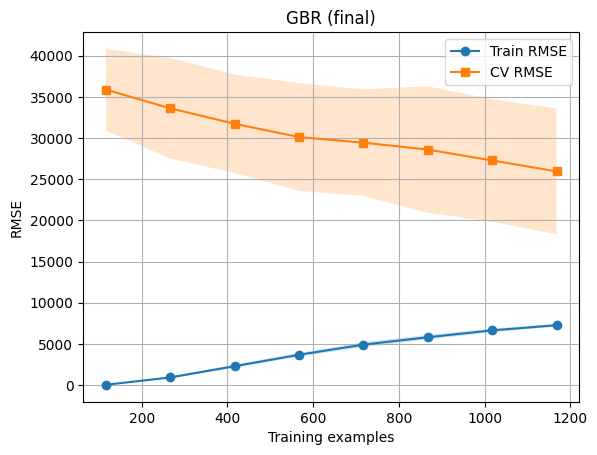

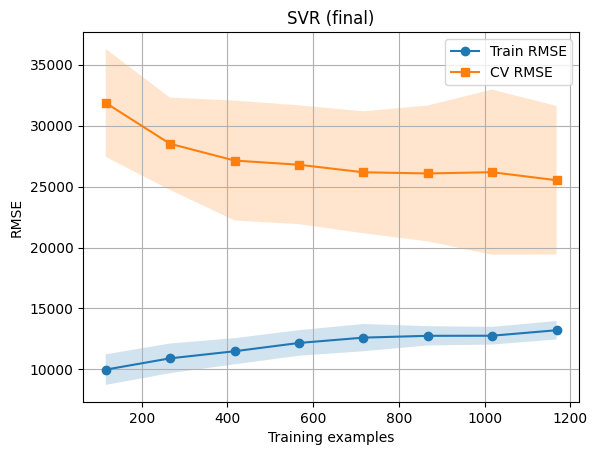

In [148]:
plot_learning_curve_rmse(gbr_grid.best_estimator_, X, y, cv, title="GBR (final)")
plot_learning_curve_rmse(svr_grid.best_estimator_, X, y, cv, title="SVR (final)")

### Error diagnostics (out-of-fold)

Out-of-fold predictions let us inspect typical error size (MAE), relative error (MAPE), and the
distribution of percentage errors. This is useful to check for skewed errors or sensitivity on high/low prices.

In [149]:
def oof_predict_repeated(estimator, X: pd.DataFrame, y: pd.Series, cv):
    preds_sum   = pd.Series(0.0, index=y.index, dtype=float)
    preds_count = pd.Series(0,   index=y.index, dtype=int)
    splits = list(cv.split(X, y))

    for tr_idx, te_idx in splits:
        est = clone(estimator)
        est.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        p = est.predict(X.iloc[te_idx])
        preds_sum.iloc[te_idx]   += p
        preds_count.iloc[te_idx] += 1

    return (preds_sum / preds_count).to_numpy()

In [150]:
def percent_err_oof(model, X, y, cv):
    y_true = pd.Series(y).reset_index(drop=True)
    y_pred = oof_predict_repeated(model, X.reset_index(drop=True), y_true, cv)
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    err = df.y_true - df.y_pred
    df["pct_err"]     = 100 * err / df.y_true.replace(0, np.nan)
    df["abs_pct_err"] = df["pct_err"].abs()
    return df

In [151]:
df_gbr = percent_err_oof(gbr_grid.best_estimator_, X, y, cv)
df_svr = percent_err_oof(svr_grid.best_estimator_, X, y, cv)
# Inspect medians/quantiles or slice by price deciles/neighborhoods
print(df_gbr["abs_pct_err"].median(), df_svr["abs_pct_err"].median())

5.8984745855096525 5.483387983477046


## Ensemble

In [154]:
def rmse(a,b): 
    return np.sqrt(np.mean((a-b)**2))

y_arr = np.asarray(y)
Z = np.c_[oof_svr, oof_gbr]           # OOF preds as features
lin = LinearRegression(positive=True, fit_intercept=False).fit(Z, y_arr)
w_svr, w_gbr = lin.coef_
w_sum = w_svr + w_gbr
w_svr, w_gbr = w_svr/w_sum, w_gbr/w_sum

ooof_blend = w_svr*oof_svr + w_gbr*oof_gbr
print(f"Weights SVR={w_svr:.3f}, GBR={w_gbr:.3f}")
print("Blend OOF RMSE:", rmse(y_arr, ooof_blend))

Weights SVR=0.424, GBR=0.576
Blend OOF RMSE: 24733.34476905391


In [152]:
def predict_blend(X_new):
    return w_svr*svr_full.predict(X_new) + w_gbr*gbr_full.predict(X_new)

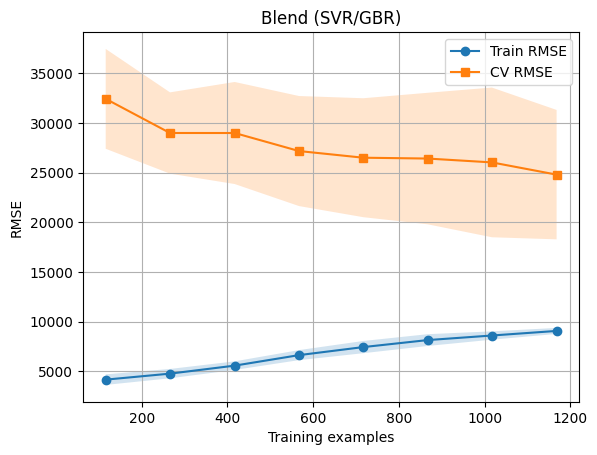

In [153]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class Blend2Regressor(BaseEstimator, RegressorMixin):
    def __init__(self, est1, est2, w1=0.5):
        self.est1 = est1
        self.est2 = est2
        self.w1 = w1
    def fit(self, X, y):
        self.m1_ = clone(self.est1).fit(X, y)
        self.m2_ = clone(self.est2).fit(X, y)
        return self
    def predict(self, X):
        return self.w1*self.m1_.predict(X) + (1-self.w1)*self.m2_.predict(X)

blend_est = Blend2Regressor(svr_grid.best_estimator_, gbr_grid.best_estimator_, w1=w_svr)
plot_learning_curve_rmse(blend_est, X, y, cv, title="Blend (SVR/GBR)")

## kaggles uses RMSLE

In [156]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    # clip to non-negative to avoid log problems
    y_true = np.asarray(y_true)
    y_pred = np.clip(np.asarray(y_pred), 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

y_arr = np.asarray(y)

# search best blend weight for RMSLE
ws = np.linspace(0, 1, 41)
best_w, best_rmsle = None, 1e9
for w in ws:
    oof_blend = w*oof_svr + (1-w)*oof_gbr
    r = rmsle(y_arr, oof_blend)
    if r < best_rmsle:
        best_rmsle, best_w = r, w

print(f"SVR OOF RMSLE:   {rmsle(y_arr, oof_svr):.5f}")
print(f"GBR OOF RMSLE:   {rmsle(y_arr, oof_gbr):.5f}")
print(f"Blend best w={best_w:.2f}  OOF RMSLE={best_rmsle:.5f}")

SVR OOF RMSLE:   0.12165
GBR OOF RMSLE:   0.12047
Blend best w=0.45  OOF RMSLE=0.11810


In [ ]:
# 0) best_est: your chosen, hyperparam-frozen pipeline from GridSearchCV.best_estimator_
best_est = gbr_grid.best_estimator_

# 1) (optional) seed-bag
seeds = [0,1,2]
bag = []
for s in seeds:
    clone_est = clone(best_est)
    clone_est.set_params(regressor__model__random_state=s)
    clone_est.fit(X, y)
    bag.append(clone_est)

# 2) diagnostic learning curve (optional)
plot_learning_curve_rmse(best_est, X, y, cv, title="GBR final (frozen)")

# Saving Models and Evaluating on Test Set

In [157]:
import joblib, json
from datetime import datetime

svr_final = clone(svr_grid.best_estimator_).fit(X, y)
gbr_final = clone(gbr_grid.best_estimator_).fit(X, y)

In [158]:
# 2) Predict test with RMSLE-optimal weights (w is SVR weight = 0.45)
w = 0.45
y_test_pred = w * svr_final.predict(X_test) + (1 - w) * gbr_final.predict(X_test)
y_test_pred = np.clip(y_test_pred, 0, None)  # RMSLE-safe (no negatives)

NameError: name 'X_test' is not defined